<a href="https://colab.research.google.com/github/hurryhurchand/ModelMLCovid/blob/main/ModeleML_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet ML sur le covid

## <font color = 'blue'> Étape 1 EDA - Exploration de données </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Lecture des données

In [2]:
df = pd.read_csv('covid.csv')

#### Afficher un échantillon de données.

In [3]:
df.sample(n=5)

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
437908,1cdd28,1,1,21-05-2020,18-05-2020,9999-99-99,97,2,40,2,2,2,2,2,2,2,2,1,2,2,99,2,97
530757,1a39a2,1,1,09-06-2020,09-06-2020,9999-99-99,97,2,49,2,2,2,2,2,2,2,2,2,2,2,99,3,97
214532,0cb736,1,1,24-05-2020,13-05-2020,9999-99-99,97,2,43,2,1,2,2,2,2,1,2,2,2,2,99,1,97
14686,0db44a,1,1,20-04-2020,16-04-2020,9999-99-99,97,2,47,2,2,2,2,2,2,2,2,2,2,2,99,1,97
72220,0a6805,2,1,04-05-2020,01-05-2020,9999-99-99,97,2,29,97,2,2,2,2,2,2,2,2,2,2,1,1,97


In [4]:
# Identifier les variables avec des données manquantes
# Valeurs manquantes peuvent êtes NULL ou 99 (d'après la documentation)

def identifierNull():
  features_with_null = [features for features in df.columns if df[features].isnull().sum() != 0]
  features_with_99   = [features for features in df.columns if int(99) in df[features].values]
  return (features_with_null,features_with_99)

a,b = identifierNull()
print("features avec null",a)
print("features avec 99",b)


features avec null []
features avec 99 ['intubed', 'pneumonia', 'age', 'contact_other_covid', 'icu']


<BarContainer object of 4 artists>

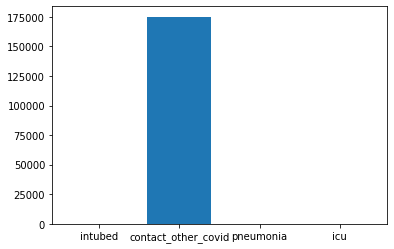

In [5]:
nombre_99 = dict()
for feature in set(b)-{"age",'entry_date','date_symptoms','date_died'}:
  nombre_99[feature] = pd.DataFrame(df[feature].value_counts()).loc[99,feature]
noms, quantite = zip(*nombre_99.items())
plt.bar(noms,quantite)


In [6]:
nombre_99

{'contact_other_covid': 175031, 'icu': 125, 'intubed': 124, 'pneumonia': 11}

In [7]:
# Juste pour la variable contact_other_covid on a un nombre important de "99"
# Ce n'est pas un prédicteur pertinent à première vue, car la présence de covid_test
# On va confirmer avec le Carmer's V test

# Pour les autres variables, la présence du code 99 est infime,et ne va pas affecter la distribution
# Donc on les suppriment
supprimer_99 = ['intubed', 'pneumonia', 'age', 'icu']
df.shape

(566602, 23)

In [8]:
# Supprimer les enregistrements avec valeurs manquantes dans la liste supprimer_99
for feature in supprimer_99:
  df[feature] = df[feature].replace(99,np.nan)
  df.dropna(subset = [feature],inplace=True)
df.shape

(566411, 23)

#### Types des variables

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566411 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   566411 non-null  object 
 1   sex                  566411 non-null  int64  
 2   patient_type         566411 non-null  int64  
 3   entry_date           566411 non-null  object 
 4   date_symptoms        566411 non-null  object 
 5   date_died            566411 non-null  object 
 6   intubed              566411 non-null  float64
 7   pneumonia            566411 non-null  float64
 8   age                  566411 non-null  float64
 9   pregnancy            566411 non-null  int64  
 10  diabetes             566411 non-null  int64  
 11  copd                 566411 non-null  int64  
 12  asthma               566411 non-null  int64  
 13  inmsupr              566411 non-null  int64  
 14  hypertension         566411 non-null  int64  
 15  other_disease    

## Optimization code

In [10]:
# On a diminuer par environ la moitié l'usage de mémoire

In [11]:
# Suprimer colonne 'contact_other_covid'
df.drop(labels=["contact_other_covid"],axis=1,inplace=True)


#### Nombre d'individu et des variables

In [12]:
dimension = df.shape
n = df.shape[0]
j = df.shape[1]
print('Dimension :', dimension)
print('les nombre des lignes est: ',n)
print('les nombre de features est: ',j)

Dimension : (566411, 22)
les nombre des lignes est:  566411
les nombre de features est:  22


In [13]:
# Variables quantitatifs continues : age
# Les autres variables sont quantatifs discrètes.

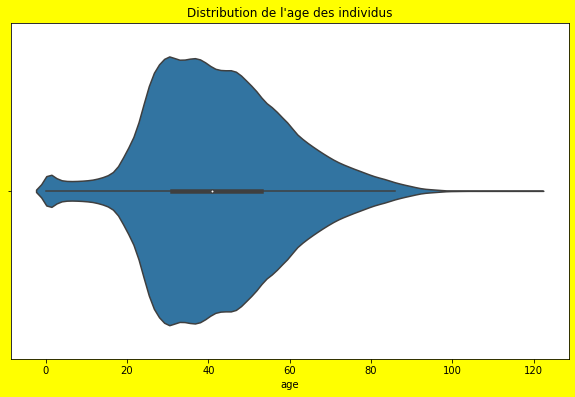

In [14]:
# Exploration variable age:
# distribution
import seaborn as sns
import matplotlib.pyplot as plt
import math
#
golden_ratio = (1+math.sqrt(5))/2
width = 10
#
plt.figure(figsize=(width,width/golden_ratio),facecolor="yellow")
plt.title("Distribution de l'age des individus")
sns.violinplot(data=df,x=df["age"])

In [15]:
df["age"].describe()

count    566411.000000
mean         42.614843
std          16.650684
min           0.000000
25%          31.000000
50%          41.000000
75%          53.000000
max         120.000000
Name: age, dtype: float64

## Observations
1. Présence d'outliers (quelques ages irréalistes)
### Correction : Suppréssion des outliers 
2. Distribution asymmétrique.
### Correction : Normalisation avec robust scaler 

In [16]:
# Traitements des outliers. Supprimer les personnes > 110 ans
df0 = df[df['age'] <= 110]

In [17]:
!pip install association-metrics

  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3952 sha256=6c9d0e340121ebdd3d5f3b8c41fb5515a082f505fafd69abf6a95602998e5d63
  Stored in directory: /root/.cache/pip/wheels/2d/1e/07/287b993a07cc41eade32a9b863d6d4686f985d72344a9e0911
Successfully built association-metrics


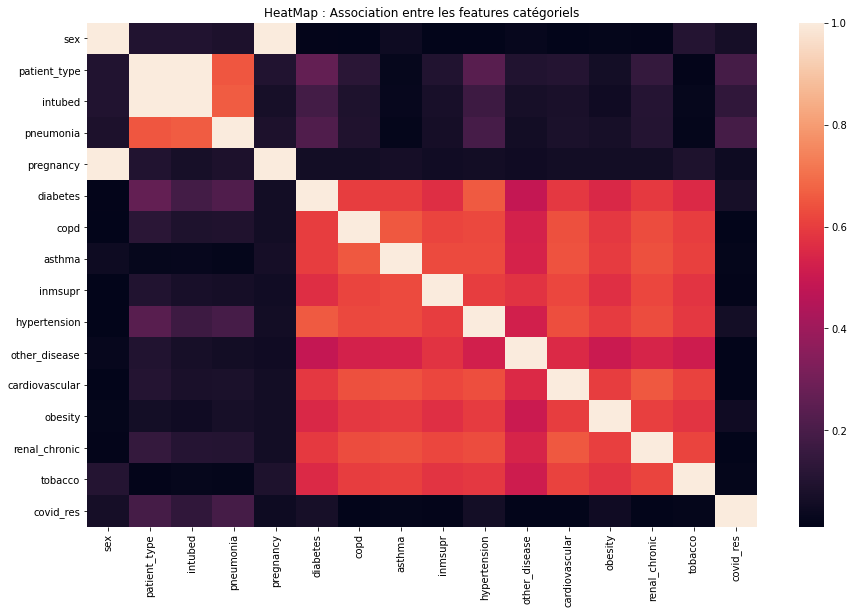

In [18]:
import association_metrics as am
# liste des variables catégorielles
lst_obj = [var_cat for var_cat in df.columns if var_cat not in ["icu","age",'entry_date','id','date_died','date_symptoms']]
df1 = df.copy()
for feature in lst_obj:
  df1[feature] = df1[feature].astype("category")
cramersv = am.CramersV(df1) 
carte = cramersv.fit()
width = 15
plt.figure(figsize=(width,width/golden_ratio))
plt.title("HeatMap : Association entre les features catégoriels")
sns.heatmap(data=carte)

## Observations : Présence des features qui sont fortement corrélées.

Solutions : Suppréssions des features corrélées lors du nettoyage des données

#### Transformation des codes 
#### Variable Pregnancy

In [19]:
df0[(df0.pregnancy == 98) & (df0.sex == 1)] # Femmes avec code 98 dans la variable pregnancy
df0['pregnancy'] = np.where((df0.sex == 1) & (df0.pregnancy == 98), 2, df0.pregnancy) # Femmes qui sont pas enceinte
# Création d'un nouveau code dans la variable pregnancy pour les hommes
df0['pregnancy'] = np.where((df0.sex == 2) & (df0.pregnancy == 97), 3, df0.pregnancy) # hommes avec code 97 dans la variable pregnancy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
df0['pregnancy'].value_counts()

3    286996
2    275336
1      4061
Name: pregnancy, dtype: int64

#### Variable intubed

In [21]:
df0['intubed'] = np.where(df0['intubed']== 99, 2, df0['intubed'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
table = pd.crosstab(df0['patient_type'], df0['intubed'])
table

intubed,1.0,2.0,97.0
patient_type,,,
1,0,0,444635
2,9964,111794,0


In [23]:
#pd.crosstab(df["patient_type"],df["icu"])
# Les patients qui ne sont renvoyés, sont donc pas admis en ICU.
# On supprime ces patients
df0 = df0[df0["patient_type"]!=1.0].copy()

In [24]:
df0.shape

(121758, 22)

#### Changer les codes 97 et 98 par 2 (non) dans les variables disease

In [25]:
columns = ['pneumonia', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']

In [26]:
for code in range(97,100):
  df0[columns] = df0[columns].applymap(lambda x: np.nan if x == code else x )

#df[columns] = df[columns].applymap(lambda x: np.nan if x in [97,98,99] else x) # suggestion


#### Feature Engineering : Création de nouvelles variables

In [27]:
df0["survived"] = df0["date_died"].map(lambda x: 1 if x=="9999-99-99" else 0)

In [28]:
Modalites = df0['survived'].value_counts()
print('Effectif : \n', Modalites)

Effectif : 
 1    89264
0    32494
Name: survived, dtype: int64


#### Variable icu

In [29]:
df0['icu'].value_counts()

2.0    111647
1.0     10111
Name: icu, dtype: int64

In [30]:
df0['icu'] = np.where((df0.icu == 97), 2, df0.icu)

df0['icu'] = np.where((df0.icu == 99), 2, df0.icu)


In [31]:
df0['icu'].value_counts()

2.0    111647
1.0     10111
Name: icu, dtype: int64

#### Variable date

In [32]:
df0.replace('9999-99-99',0,inplace = True)

#### Feature Engineering : Création Variable Wait time

In [33]:
from datetime import datetime
#datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')



def to_days(x):
  return datetime.strptime(x, '%d-%m-%Y').date()

df0["wait_time"] = df0["entry_date"].map(lambda x:to_days(x))-df0["date_symptoms"].map(lambda x:to_days(x))
df0["wait_time"] = df0["wait_time"].map(lambda x:x.days)


In [34]:
df0['wait_time'].unique()

array([  5,   7,   0,   9,   6,   3,   8,   4,  11,  10,   1,   2,  14,
        13,  12,  17,  15,  16,  41,  36,  33,  20,  24,  35,  68,  23,
        38,  25,  30,  39,  27,  18,  90,  70,  29,  42,  69,  32,  22,
        19,  21,  53,  83,  37,  49,  65,  26,  58,  48, 115])

#### Remplir les valeurs manquantes avec KNN

In [35]:
NaN_Rows_Ids = df0[df0.isna().any(axis=1)].index

In [38]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

In [39]:
X = df0.select_dtypes(include =['int32','float64']).columns.tolist()

In [40]:
df_KNN = df0.copy()

In [41]:
df_KNN[X] =imputer.fit_transform(df_KNN[X])

In [43]:
dimension = df_KNN.shape
n = df0.shape[0]
j = df0.shape[1]
print('Dimension :', dimension)
print('les nombre des lignes est: ',n)
print('les nombre des colonnes est: ',j)

Dimension : (121758, 24)
les nombre des lignes est:  121758
les nombre des colonnes est:  24


In [44]:
df_KNN.to_csv('Data_KNN_finalV2.csv')

## <font color = 'blue'> Étape 3 Sélection des prédicteurs </font>

In [45]:
df_KNN.head(2)

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu,survived,wait_time
2,167386,1,2,06-04-2020,01-04-2020,0,2.0,2.0,54.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1,2.0,1,5
3,0b5948,2,2,17-04-2020,10-04-2020,0,2.0,1.0,30.0,3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,2.0,1,7


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [47]:
X = ['sex','patient_type','intubed','pneumonia'] + list(df_KNN.loc[:,'pregnancy':'covid_res']) + ['age','wait_time']
print(X)
y = df_KNN.loc[:,'icu']
df2 = df_KNN[X]


['sex', 'patient_type', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'covid_res', 'age', 'wait_time']


In [48]:
df2

,sex,patient_type,intubed,pneumonia,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,age,wait_time
2,1,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1,54.0,5
3,2,2,2.0,1.0,3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,30.0,7
4,1,2,2.0,2.0,2,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1,60.0,0
5,2,2,2.0,1.0,3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,47.0,0
6,2,2,2.0,2.0,3,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1,63.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566584,2,2,2.0,1.0,3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,45.0,0
566590,2,2,1.0,1.0,3,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3,68.0,14
566591,2,2,1.0,1.0,3,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,48.0,0
566593,1,2,2.0,1.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,31.0,3


In [49]:
clf = RandomForestClassifier(n_jobs=2, random_state=42)

clf.fit(df2, y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [69]:
#Importance des predicteurs

listePredicteurs = list(zip(df2,clf.feature_importances_))
listePredicteurs.sort(key = lambda x: x[1], reverse = True)
display(listePredicteurs)


[('age', 0.4197792632288766),
 ('intubed', 0.25184806899606893),
 ('wait_time', 0.14822603534525966),
 ('covid_res', 0.03275673386235804),
 ('diabetes', 0.019006501151689805),
 ('hypertension', 0.01868340008994309),
 ('pneumonia', 0.016648398311314087),
 ('tobacco', 0.013625181039225083),
 ('other_disease', 0.012055108902056045),
 ('obesity', 0.011730914552539355),
 ('cardiovascular', 0.010195598511994326),
 ('renal_chronic', 0.009814566558623864),
 ('copd', 0.008532531067352472),
 ('inmsupr', 0.008513672650272088),
 ('asthma', 0.006736632490505085),
 ('pregnancy', 0.006633440797679679),
 ('sex', 0.005213952444241842),
 ('patient_type', 0.0)]

In [70]:
## Nous remarquons que les prédicteurs sont choisis par degré d'importance par le random classifier
## nous remaquons que certain prédicteur qu'on  important sont descriminé comme l'asthme.
## si nous avions fait le choix pour l'intervention d'un medecin spécialiste peux faire la selection
## celà pourrait sans doute changer certains predicteurs.

## <font color = 'blue'> Étape 3 Création des modèles </font>

#### Création de sous-ensembles Training and Test

In [73]:
# Prendre les features important
feature_cols = [features[0] for features in listePredicteurs if features[1] > 0]
X1 = df_KNN.loc[:,feature_cols]
y1 = df_KNN.loc[:,'icu']

In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,test_size = 0.2, random_state = 44)
print ("Taille training",X_train1.shape, y_train1.shape)
print ("Taille test",X_test1.shape, y_test1.shape)

Taille training (97406, 17) (97406,)
Taille test (24352, 17) (24352,)


#### Abre de décision:

#### Entrainement de l'abre de décision - Approche avec gini

In [75]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
classifier = DecisionTreeClassifier(criterion='gini', random_state=44, max_depth=6, min_samples_leaf=5) 

In [76]:
classifier.fit(X_train1,y_train1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=44, splitter='best')

#### Test l'abre de décision Prediction

In [77]:
from sklearn import metrics
y_pred = classifier.predict(X_test1)
print("l'accuracy de larble de decision est:", "{:.3f}".format(metrics.accuracy_score(y_test1,y_pred)))

l'accuracy de larble de decision est: 0.920


In [78]:
# Utiliser weighted average, avec données non-balancées
print ("Precision:", metrics.precision_score(y_test1, y_pred,average="weighted") )
print ("Recall:", metrics.recall_score(y_test1, y_pred,average="weighted"))
print ("F1 score:", metrics.f1_score(y_test1, y_pred,average="weighted") )

Precision: 0.9021351888376862
Recall: 0.9196369908015769
F1 score: 0.9058237053636147


In [79]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus
import os 

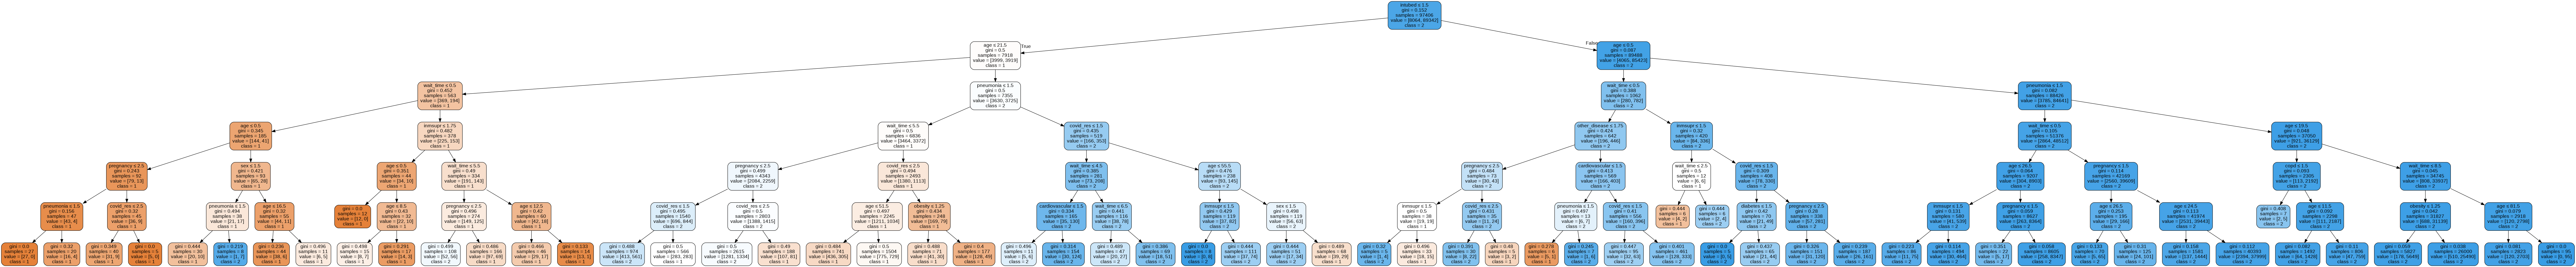

In [80]:
dot_data = StringIO()


export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('covid.png')
Image(graph.create_png())


#### Random forest

In [86]:
clf = RandomForestClassifier(n_jobs=2, random_state=44)

clf.fit(X_train1, y_train1)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=44,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

In [87]:
#Prediction
preds = clf.predict(X_test1)

In [88]:
#Matrice confusion
pd.crosstab(y_test1, preds, rownames=['Vrais résultats'], colnames=['Résultats prédits'])

Résultats prédits,1.0,2.0
Vrais résultats,,
1.0,536,1511
2.0,725,21580


In [93]:
print ("Precision:", metrics.precision_score(y_test1, preds, average="weighted") )
print ("Recall:", metrics.recall_score(y_test1, preds, average="weighted") )
print ("F1 score:", metrics.f1_score(y_test1, preds, average="weighted") )

Precision: 0.8917349718424745
Recall: 0.908180026281209
F1 score: 0.8980664462598463


## OPTIMISER LE CODE

In [94]:
# Convertir les int64 en int32
for feature in df_KNN.select_dtypes(include=["int64","float64"]):
  df_KNN[feature] = df_KNN[feature].astype(np.int32)

Comparaison plusieurs algorithmes

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from random import sample

from sklearn.model_selection import train_test_split
listCol = feature_cols
#dic = {}
#for n_neighbors in range(22):
#    rec=[]
#    for k in range(10):
## Si on choisit de ne pas utiliser tout le database et faire un undersampling, choisit undersampling = 1
## sinon tout autre chiffre

undersampling = 0
if (undersampling == 1):
    rowCat1 = df_KNN[df_KNN["icu"] == 1].index.tolist()
    rowCat2 = df_KNN[df_KNN["icu"] == 2].index.tolist()
    rowCat3 = sample(rowCat2,len(rowCat1))
    rows = rowCat1 + rowCat3 
#    
    X = df_KNN.loc[rows,listCol]
    y = df_KNN.loc[rows,"icu"]
else:
    X = df_KNN[listCol]
    y = df_KNN["icu"]

from sklearn.model_selection import RepeatedKFold
###################################################################################

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)



algorithms = [("KNN",KNeighborsClassifier(n_neighbors = 11)),
              ("LR",LogisticRegression(max_iter=10000)),
              ("DT",DecisionTreeClassifier(random_state=44)), 
              ("RF",RandomForestClassifier(random_state=44)),
              ("SVM",SVC(random_state=44)),("XGBOOST",GradientBoostingClassifier(random_state=44,max_depth=6)),
              ("NNetwork",MLPClassifier(hidden_layer_sizes = (8,8,8), activation='tanh', max_iter=700))]

def metrics(y_test,y_pred):
  from sklearn import metrics
  accuracy = metrics.accuracy_score(y_test,y_pred)
  CM = confusion_matrix(y_test, y_pred)

  precision = metrics.precision_score(y_test,y_pred, average="weighted")
  recall = metrics.recall_score(y_test,y_pred, average="weighted")
  f1 = metrics.f1_score(y_test,y_pred, average="weighted")
  return (name,f1,precision,recall,accuracy)

sm = []    
for name,model in algorithms:
    for train_index, test_index in rkf.split(X,y):
#    print("Train:", train_index, "Validation:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
###################################################################################
      


    model.fit(X_train1,y_train1)
    y_pred = model.predict(X_test1)
    sm.append(metrics(y_test1,y_pred))
    
    df_sm = pd.DataFrame(sm,columns=["name","f1","precision","recall","accuracy"])


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
df_sm_groupBy = df_sm.groupby(by=["name"]).mean()
df_sm_groupBy

,f1,precision,recall,accuracy
name,,,,
DT,0.882134,0.881756,0.882515,0.882515
KNN,0.881504,0.883402,0.915941,0.915941
LR,0.909064,0.905253,0.920664,0.920664
NNetwork,0.910420,0.906456,0.916434,0.916434
RF,0.898066,0.891735,0.908180,0.908180
SVM,0.875756,0.838948,0.915941,0.915941
XGBOOST,0.905638,0.901204,0.918282,0.918282


Text(0.5, 1.0, 'Performance des méthodes')

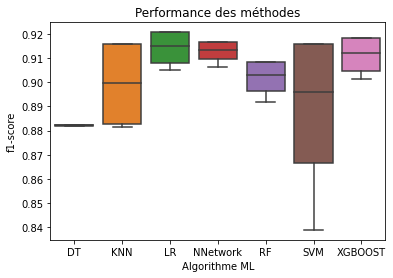

In [102]:
sns.boxplot(data=df_sm_groupBy.T)
plt.ylabel("f1-score")
plt.xlabel("Algorithme ML")
plt.title("Performance des méthodes")